# Setup

Imports and reproducibility

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.anova import anova_lm

In [ ]:
np.random.seed(123)
rng = np.random.default_rng(123)

# Data Reading & Preview

In [ ]:
path = "cycling.txt"
df_raw = pd.read_csv(path, sep=None, engine="python", dtype=str)

In [ ]:
df_raw.head()

,all_riders,rider_class,stage,points,stage_class
0,Tadej Pogačar,All Rounder,X1,15,flat
1,Tadej Pogačar,All Rounder,X2,219,hills
2,Tadej Pogačar,All Rounder,X3,34,flat
3,Tadej Pogačar,All Rounder,X4,264,hills
4,Tadej Pogačar,All Rounder,X6,114,hills


# Data Cleaning

In [ ]:
def clean_colname(c):
    c = c.strip().lower()
    c = re.sub(r"[^\w]+", "_", c)
    c = re.sub(r"_{2,}", "_", c).strip("_")
    return c

In [ ]:
df = df_raw.copy()
df.columns = [clean_colname(c) for c in df.columns]

In [ ]:
def trim_quotes(x):
    if pd.isna(x):
        return x
    x = str(x).strip()
    if len(x) >= 2 and ((x[0] == x[-1] == '"') or (x[0] == x[-1] == "'")):
        x = x[1:-1].strip()
    return x

In [ ]:
for c in df.columns:
    df[c] = df[c].map(trim_quotes)

In [ ]:
required_cols = ["all_riders", "rider_class", "stage", "points", "stage_class"]
missing = [c for c in required_cols if c not in df.columns]

if missing:
    raise ValueError(f"Missing columns: {missing}. Found: {list(df.columns)}")

In [ ]:
df["points_raw"] = df["points"]
df["points"] = pd.to_numeric(df["points"], errors="coerce")

# Data Integrity Checks

In [ ]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (3496, 6)


In [ ]:
print("Column dtypes:")
print(df.dtypes)

Column dtypes:
all_riders     object
rider_class    object
stage          object
points          int64
stage_class    object
points_raw     object
dtype: object


In [ ]:
print("Missing values per column:")
print(df.isna().sum().sort_values(ascending=False))

Missing values per column:
all_riders     0
rider_class    0
stage          0
points         0
stage_class    0
points_raw     0
dtype: int64


In [ ]:
print(f"Duplicated rows: {int(df.duplicated().sum())}")

Duplicated rows: 0


In [ ]:
bad_points = df["points"].isna() & df["points_raw"].notna() & (df["points_raw"].astype(str).str.strip() != "")
print(f"Non-empty points coerced to NaN: {int(bad_points.sum())}")

if bad_points.sum() > 0:
    print(df.loc[bad_points, "points_raw"].value_counts().head(10))

Non-empty points coerced to NaN: 0


In [ ]:
stage_to_class_n = df.groupby("stage")["stage_class"].nunique()
rider_to_class_n = df.groupby("all_riders")["rider_class"].nunique()

print("Consistency checks:")
print("Stage - number of unique stage_class labels:")
print(stage_to_class_n.value_counts().sort_index())
print("Rider - number of unique rider_class labels:")
print(rider_to_class_n.value_counts().sort_index())

Consistency checks:
Stage - number of unique stage_class labels:
stage_class
1    19
Name: count, dtype: int64
Rider - number of unique rider_class labels:
rider_class
1    184
Name: count, dtype: int64


In [ ]:
obs_per_rider = df.groupby("all_riders").size()
obs_per_stage = df.groupby("stage").size()

print("Repeated-observation structure:")
print(f"Observations per rider (min / median / mean / max): "
      f"{int(obs_per_rider.min())} / {float(obs_per_rider.median())} / "
      f"{float(obs_per_rider.mean())} / {int(obs_per_rider.max())}")
print(f"Observations per stage (min / median / mean / max): "
      f"{int(obs_per_stage.min())} / {float(obs_per_stage.median())} / "
      f"{float(obs_per_stage.mean())} / {int(obs_per_stage.max())}")

Repeated-observation structure:
Observations per rider (min / median / mean / max): 19 / 19.0 / 19.0 / 19
Observations per stage (min / median / mean / max): 184 / 184.0 / 184.0 / 184


# Descriptive Analysis

In [ ]:
df_nonmissing = df.loc[df["points"].notna()].copy()

print("COUNTS: rider_class")
print(df["rider_class"].value_counts())

COUNTS: rider_class
rider_class
Unclassed      2185
Sprinter        551
Climber         437
All Rounder     323
Name: count, dtype: int64


In [ ]:
print("COUNTS: stage_class")
print(df["stage_class"].value_counts())

COUNTS: stage_class
stage_class
hills    1472
flat     1104
mount     920
Name: count, dtype: int64


In [ ]:
print("CROSS-TAB: rider_class x stage_class")
print(pd.crosstab(df["rider_class"], df["stage_class"]))

CROSS-TAB: rider_class x stage_class
stage_class  flat  hills  mount
rider_class                    
All Rounder   102    136     85
Climber       138    184    115
Sprinter      174    232    145
Unclassed     690    920    575


In [ ]:
p = df_nonmissing["points"]
print("POINTS: OVERALL SUMMARY")
print(p.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]))
print("Proportion zeros:", round((p == 0).mean(), 4))

POINTS: OVERALL SUMMARY
count    3496.000000
mean       12.385297
std        36.285334
min         0.000000
1%          0.000000
5%          0.000000
25%         0.000000
50%         0.000000
75%         8.000000
95%        74.000000
99%       212.000000
max       304.000000
Name: points, dtype: float64
Proportion zeros: 0.6181


# Histogram of Points (Overall)

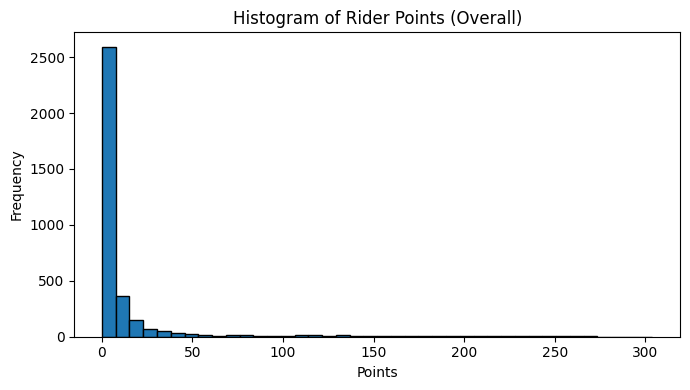

In [ ]:
plt.figure(figsize=(7, 4))
plt.hist(df_nonmissing["points"], bins=40, edgecolor="black")
plt.xlabel("Points")
plt.ylabel("Frequency")
plt.title("Histogram of Rider Points (Overall)")
plt.tight_layout()
plt.show()

In [ ]:
print("POINTS: BY rider_class (mean/sd/median/q25/q75/zero_prop)")
summary_r = (df_nonmissing.groupby("rider_class")["points"]
             .agg(n="size",
                  mean="mean",
                  sd="std",
                  median="median",
                  q25=lambda x: x.quantile(0.25),
                  q75=lambda x: x.quantile(0.75),
                  min="min",
                  max="max",
                  zero_prop=lambda x: (x==0).mean())
             .sort_values("n", ascending=False))
print(summary_r)

POINTS: BY rider_class (mean/sd/median/q25/q75/zero_prop)
                n       mean         sd  median  q25   q75  min  max  \
rider_class                                                            
Unclassed    2185   6.419680  23.282527     0.0  0.0   2.0    0  260   
Sprinter      551  15.036298  41.832247     0.0  0.0   4.0    0  272   
Climber       437  20.169336  43.447254     6.0  0.0  16.0    0  269   
All Rounder   323  37.687307  63.961640    12.0  0.0  39.5    0  304   

             zero_prop  
rider_class             
Unclassed     0.694737  
Sprinter      0.649728  
Climber       0.389016  
All Rounder   0.356037  


In [ ]:
print("POINTS: BY stage_class (mean/sd/median/q25/q75/zero_prop)")
summary_s = (df_nonmissing.groupby("stage_class")["points"]
             .agg(n="size",
                  mean="mean",
                  sd="std",
                  median="median",
                  q25=lambda x: x.quantile(0.25),
                  q75=lambda x: x.quantile(0.75),
                  min="min",
                  max="max",
                  zero_prop=lambda x: (x==0).mean())
             .sort_values("n", ascending=False))
print(summary_s)

POINTS: BY stage_class (mean/sd/median/q25/q75/zero_prop)
                n       mean         sd  median  q25  q75  min  max  zero_prop
stage_class                                                                   
hills        1472  12.520380  36.130357     0.0  0.0  8.0    0  274   0.612772
flat         1104  11.794384  33.219268     0.0  0.0  8.0    0  272   0.586051
mount         920  12.878261  39.906588     0.0  0.0  4.0    0  304   0.665217


In [ ]:
print("POINTS: BY rider_class x stage_class")
summary_rs = (df_nonmissing.groupby(["rider_class","stage_class"])["points"]
              .agg(n="size",
                   mean="mean",
                   sd="std",
                   median="median",
                   q25=lambda x: x.quantile(0.25),
                   q75=lambda x: x.quantile(0.75),
                   zero_prop=lambda x: (x==0).mean())
              .reset_index())
print(summary_rs.sort_values(["rider_class","stage_class"]).to_string(index=False))

POINTS: BY rider_class x stage_class
rider_class stage_class   n      mean        sd  median  q25   q75  zero_prop
All Rounder        flat 102 15.441176 28.281671     8.0  0.0 19.25   0.411765
All Rounder       hills 136 35.786765 57.459217    12.5  0.0 41.50   0.323529
All Rounder       mount  85 67.423529 88.955898    17.0  0.0 99.00   0.341176
    Climber        flat 138  5.094203  6.230239     1.5  0.0  8.75   0.463768
    Climber       hills 184 21.668478 45.984482     7.0  0.0 16.50   0.369565
    Climber       mount 115 35.860870 57.019985    12.0  0.0 36.00   0.330435
   Sprinter        flat 174 38.977011 63.588267     2.5  0.0 50.00   0.471264
   Sprinter       hills 232  5.202586 21.950897     0.0  0.0  2.00   0.702586
   Sprinter       mount 145  2.041379  5.886515     0.0  0.0  0.00   0.779310
  Unclassed        flat 690  5.740580 19.801356     0.0  0.0  3.75   0.665217
  Unclassed       hills 920  9.096739 30.662585     0.0  0.0  3.00   0.681522
  Unclassed       mount 575

In [ ]:
df["pos"] = (df["points"] > 0).astype(int)
p_pos_tab = (df.groupby(["rider_class","stage_class"])["pos"]
             .agg(n="size", p_pos="mean")
             .reset_index())
print("TABLE: P(points>0) by rider_class x stage_class")
print(p_pos_tab.sort_values(["rider_class","stage_class"]).to_string(index=False))

TABLE: P(points>0) by rider_class x stage_class
rider_class stage_class   n    p_pos
All Rounder        flat 102 0.588235
All Rounder       hills 136 0.676471
All Rounder       mount  85 0.658824
    Climber        flat 138 0.536232
    Climber       hills 184 0.630435
    Climber       mount 115 0.669565
   Sprinter        flat 174 0.528736
   Sprinter       hills 232 0.297414
   Sprinter       mount 145 0.220690
  Unclassed        flat 690 0.334783
  Unclassed       hills 920 0.318478
  Unclassed       mount 575 0.248696


In [ ]:
mean_pos_tab = (df.loc[df["points"]>0]
                .groupby(["rider_class","stage_class"])["points"]
                .agg(n_pos="size", mean_pos="mean", median_pos="median")
                .reset_index())
print("TABLE: Mean points | points>0 by rider_class x stage_class")
print(mean_pos_tab.sort_values(["rider_class","stage_class"]).to_string(index=False))

TABLE: Mean points | points>0 by rider_class x stage_class
rider_class stage_class  n_pos   mean_pos  median_pos
All Rounder        flat     60  26.250000        13.0
All Rounder       hills     92  52.902174        24.0
All Rounder       mount     56 102.339286        80.5
    Climber        flat     74   9.500000         8.0
    Climber       hills    116  34.370690        12.0
    Climber       mount     77  53.558442        25.0
   Sprinter        flat     92  73.717391        50.0
   Sprinter       hills     69  17.492754         6.0
   Sprinter       mount     32   9.250000         4.0
  Unclassed        flat    231  17.147186         8.0
  Unclassed       hills    293  28.563140         8.0
  Unclassed       mount    143  11.867133         8.0


# Points by Stage Class and Rider Class

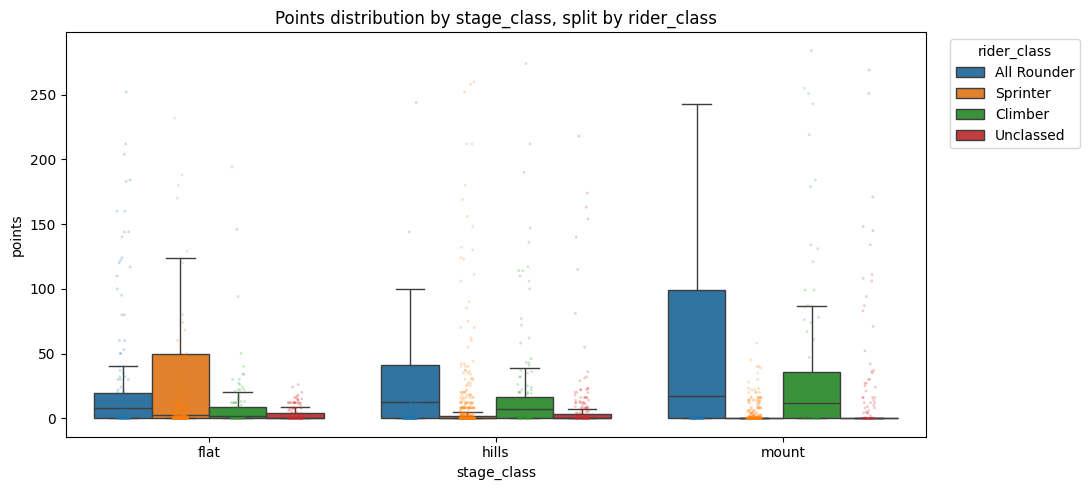

In [ ]:
plt.figure(figsize=(11, 5))
sns.boxplot(data=df_nonmissing, x="stage_class", y="points", hue="rider_class", showfliers=False)
sns.stripplot(
    data=df_nonmissing.sample(min(len(df_nonmissing), 2000), random_state=123),
    x="stage_class", y="points", hue="rider_class",
    dodge=True, alpha=0.25, size=2
)
handles, labels = plt.gca().get_legend_handles_labels()
seen, h2, l2 = set(), [], []
for h, lab in zip(handles, labels):
    if lab not in seen:
        seen.add(lab); h2.append(h); l2.append(lab)
plt.legend(h2, l2, title="rider_class", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.title("Points distribution by stage_class, split by rider_class")
plt.tight_layout()
plt.show()

# Heatmaps of Mean Points and P(points > 0)

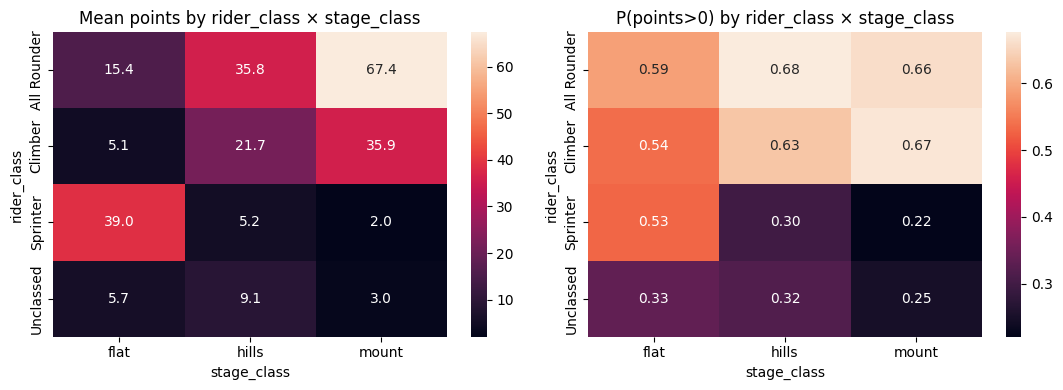

In [ ]:
mean_mat = df.pivot_table(index="rider_class", columns="stage_class", values="points", aggfunc="mean")
ppos_mat = df.pivot_table(index="rider_class", columns="stage_class", values="pos", aggfunc="mean")
fig, axes = plt.subplots(1, 2, figsize=(11, 4))
sns.heatmap(mean_mat, annot=True, fmt=".1f", ax=axes[0])
axes[0].set_title("Mean points by rider_class × stage_class")
sns.heatmap(ppos_mat, annot=True, fmt=".2f", ax=axes[1])
axes[1].set_title("P(points>0) by rider_class × stage_class")
plt.tight_layout()
plt.show()

# Methods: Part A — Probability of Scoring (Mixed-Effects Logistic Model)

In [ ]:
df["rider_class"] = df["rider_class"].astype("category")
df["stage_class"] = df["stage_class"].astype("category")
df["stage"] = df["stage"].astype("category")
df["all_riders"] = df["all_riders"].astype("category")

vcf = {"rider": "0 + C(all_riders)", "stage": "0 + C(stage)"}
modelA = sm.BinomialBayesMixedGLM.from_formula(
    "pos ~ rider_class * stage_class",
    vcf,
    data=df
)
resA = modelA.fit_vb()

print("Part A: Binomial mixed model (VB) summary")
print(resA.summary())

Part A: Binomial mixed model (VB) summary
                                 Binomial Mixed GLM Results
                                              Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
--------------------------------------------------------------------------------------------
Intercept                                        M     0.6140   0.0432                      
rider_class[T.Climber]                           M    -0.4013   0.1229                      
rider_class[T.Sprinter]                          M    -0.3670   0.1092                      
rider_class[T.Unclassed]                         M    -1.4813   0.0541                      
stage_class[T.hills]                             M     0.5333   0.0662                      
stage_class[T.mount]                             M     0.3775   0.0894                      
rider_class[T.Climber]:stage_class[T.hills]      M     0.0680   0.1897                      
rider_class[T.Sprinter]:stage_class[T.hills]     M    -1.8570

In [ ]:
fe_names_A = modelA.exog_names
fe_mean_A = np.asarray(resA.fe_mean)
fe_sd_A = np.asarray(resA.fe_sd)

feA = pd.DataFrame({
    "term": fe_names_A,
    "post_mean": fe_mean_A,
    "post_sd": fe_sd_A,
    "OR": np.exp(fe_mean_A),
    "OR_low_approx": np.exp(fe_mean_A - 1.96*fe_sd_A),
    "OR_high_approx": np.exp(fe_mean_A + 1.96*fe_sd_A),
})
print("Part A fixed effects (OR scale; approx 95% intervals)")
print(feA.to_string(index=False))

Part A fixed effects (OR scale; approx 95% intervals)
                                         term  post_mean  post_sd       OR  OR_low_approx  OR_high_approx
                                    Intercept   0.613972 0.043185 1.847755       1.697792        2.010964
                       rider_class[T.Climber]  -0.401347 0.122910 0.669418       0.526107        0.851767
                      rider_class[T.Sprinter]  -0.367022 0.109202 0.692794       0.559306        0.858142
                     rider_class[T.Unclassed]  -1.481307 0.054131 0.227340       0.204456        0.252787
                         stage_class[T.hills]   0.533343 0.066175 1.704621       1.497263        1.940695
                         stage_class[T.mount]   0.377454 0.089380 1.458566       1.224176        1.737833
  rider_class[T.Climber]:stage_class[T.hills]   0.067970 0.189732 1.070333       0.737930        1.552467
 rider_class[T.Sprinter]:stage_class[T.hills]  -1.856968 0.170820 0.156145       0.111718        0

### Part A Results — Predicted Probabilities and Planned Contrasts

In [ ]:
gridA = pd.DataFrame(
    [(rc, sc) for rc in df["rider_class"].cat.categories for sc in df["stage_class"].cat.categories],
    columns=["rider_class", "stage_class"]
)
XgA = dmatrix(modelA.data.design_info, gridA, return_type="dataframe")
xbA = np.asarray(XgA @ fe_mean_A)
p_hat_A = 1 / (1 + np.exp(-xbA))

In [ ]:
B = 8000
drawsA = rng.normal(loc=fe_mean_A, scale=fe_sd_A, size=(B, len(fe_mean_A)))
xb_drawsA = drawsA @ XgA.values.T
p_drawsA = 1 / (1 + np.exp(-xb_drawsA))
p_low_A = np.quantile(p_drawsA, 0.025, axis=0)
p_high_A = np.quantile(p_drawsA, 0.975, axis=0)

predA = gridA.copy()
predA["p_hat"] = p_hat_A
predA["p_low_approx"] = p_low_A
predA["p_high_approx"] = p_high_A

print("Part A: Predicted P(points>0) by rider_class × stage_class (approx 95% intervals)")
print(predA.sort_values(["rider_class","stage_class"]).to_string(index=False))

Part A: Predicted P(points>0) by rider_class × stage_class (approx 95% intervals)
rider_class stage_class    p_hat  p_low_approx  p_high_approx
All Rounder        flat 0.648846      0.628783       0.668200
All Rounder       hills 0.759020      0.730253       0.786616
All Rounder       mount 0.729369      0.688674       0.765533
    Climber        flat 0.552957      0.489500       0.614767
    Climber       hills 0.692948      0.587217       0.784926
    Climber       mount 0.746168      0.624512       0.837499
   Sprinter        flat 0.561426      0.502865       0.615620
   Sprinter       hills 0.254136      0.182860       0.340624
   Sprinter       mount 0.161146      0.100776       0.249275
  Unclassed        flat 0.295809      0.268024       0.325198
  Unclassed       hills 0.275026      0.229323       0.326738
  Unclassed       mount 0.191909      0.147417       0.244042


In [ ]:
cellsA = list(zip(predA["rider_class"], predA["stage_class"]))
cell_index_A = {c:i for i,c in enumerate(cellsA)}

In [ ]:
def prob_contrast(cell1, cell0):
    i1, i0 = cell_index_A[cell1], cell_index_A[cell0]
    d = p_drawsA[:, i1] - p_drawsA[:, i0]
    return float(d.mean()), float(np.quantile(d, 0.025)), float(np.quantile(d, 0.975))

In [ ]:
classes = list(df["rider_class"].cat.categories)
stages = list(df["stage_class"].cat.categories)

rowsA = []

ref_class = "All Rounder"
for sc in stages:
    for rc in classes:
        if rc == ref_class:
            continue
        m, lo, hi = prob_contrast((rc, sc), (ref_class, sc))
        rowsA.append({
            "contrast_type": "Class vs All Rounder (within stage)",
            "stage_class": sc,
            "contrast": f"{rc} - {ref_class}",
            "diff_p": m,
            "CI_low": lo,
            "CI_high": hi
        })

In [ ]:
ref_stage = "flat"
for rc in classes:
    for sc in stages:
        if sc == ref_stage:
            continue
        m, lo, hi = prob_contrast((rc, sc), (rc, ref_stage))
        rowsA.append({
            "contrast_type": "Stage vs flat (within class)",
            "stage_class": f"{sc} - {ref_stage}",
            "contrast": rc,
            "diff_p": m,
            "CI_low": lo,
            "CI_high": hi
        })

In [ ]:
ctA = pd.DataFrame(rowsA)

ctA["se_approx"] = (ctA["CI_high"] - ctA["CI_low"]) / (2 * 1.96)
ctA["z_approx"] = ctA["diff_p"] / ctA["se_approx"]
ctA["p_raw"] = 2 * (1 - st.norm.cdf(np.abs(ctA["z_approx"])))

rejectA, p_holmA, _, _ = multipletests(ctA["p_raw"].values, alpha=0.05, method="holm")
ctA["p_holm"] = p_holmA
ctA["reject_holm_0.05"] = rejectA

print("Part A planned contrasts with Holm adjustment")
print(ctA[["contrast_type","stage_class","contrast","diff_p","CI_low","CI_high","p_raw","p_holm","reject_holm_0.05"]]
      .sort_values(["contrast_type","stage_class","contrast"])
      .to_string(index=False))

Part A planned contrasts with Holm adjustment
                      contrast_type  stage_class                contrast    diff_p    CI_low   CI_high    p_raw   p_holm  reject_holm_0.05
Class vs All Rounder (within stage)         flat   Climber - All Rounder -0.096475 -0.155383 -0.036620 0.001451 0.005803              True
Class vs All Rounder (within stage)         flat  Sprinter - All Rounder -0.087750 -0.140457 -0.036709 0.000915 0.005488              True
Class vs All Rounder (within stage)         flat Unclassed - All Rounder -0.352763 -0.374776 -0.329402 0.000000 0.000000              True
Class vs All Rounder (within stage)        hills   Climber - All Rounder -0.067535 -0.166176  0.020193 0.155462 0.466385             False
Class vs All Rounder (within stage)        hills  Sprinter - All Rounder -0.502363 -0.570506 -0.424052 0.000000 0.000000              True
Class vs All Rounder (within stage)        hills Unclassed - All Rounder -0.482686 -0.519827 -0.442989 0.000000 0.000000

# Methods: Part B - Points Given a Positive Score (Linear Mixed Model)

In [ ]:
df_pos = df.loc[df["points"] > 0].copy()
df_pos["log_points"] = np.log(df_pos["points"])
df_pos["rider_class"] = df_pos["rider_class"].astype("category")
df_pos["stage_class"] = df_pos["stage_class"].astype("category")

print(f"Positive-only data shape: {df_pos.shape}")

Positive-only data shape: (1335, 8)


In [ ]:
vc = {"stage": "0 + C(stage)"}
lmm = smf.mixedlm(
    "log_points ~ rider_class * stage_class",
    data=df_pos,
    groups=df_pos["all_riders"],
    vc_formula=vc,
    re_formula="1"
)
lmm_res = lmm.fit(reml=True, method="lbfgs")
print("Part B LMM SUMMARY (log(points) | points>0)")
print(lmm_res.summary())

Part B LMM SUMMARY (log(points) | points>0)
                         Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           log_points
No. Observations:             1335              Method:                       REML      
No. Groups:                   176               Scale:                        0.5310    
Min. group size:              1                 Log-Likelihood:               -2086.9766
Max. group size:              19                Converged:                    Yes       
Mean group size:              7.6                                                       
----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                      2.595    0.210 12.337 0.000  2.183  3.007
rid

In [ ]:
fitted = lmm_res.fittedvalues
resid = df_pos["log_points"] - fitted

print("Part B residual diagnostics:")
print(f"Residual mean: {float(resid.mean()):.4f}")
print(f"Residual SD: {float(resid.std(ddof=1)):.4f}")
print(f"Skewness: {float(st.skew(resid)):.4f}")
print(f"Excess kurtosis: {float(st.kurtosis(resid)):.4f}")

Part B residual diagnostics:
Residual mean: 0.0000
Residual SD: 0.4748
Skewness: 0.2952
Excess kurtosis: 0.2193


# Part B: Diagnostics

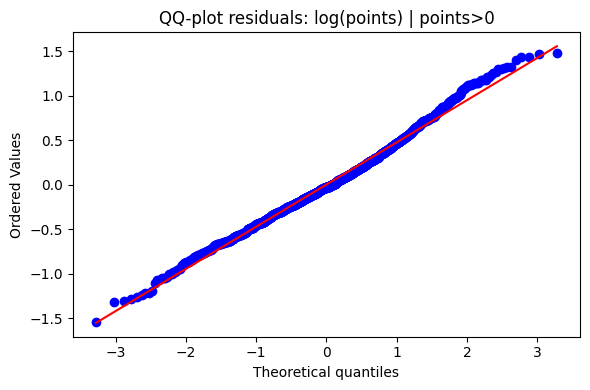

In [ ]:
plt.figure(figsize=(6,4))
st.probplot(resid, dist="norm", plot=plt)
plt.title("QQ-plot residuals: log(points) | points>0")
plt.tight_layout()
plt.show()

## Part B Results — Geometric Mean Ratios and Planned Contrasts

In [ ]:
beta = lmm_res.fe_params
covb = lmm_res.cov_params().loc[beta.index, beta.index]

classes_pos = list(df_pos["rider_class"].cat.categories)
stages_pos = list(df_pos["stage_class"].cat.categories)

gridB = pd.DataFrame([(rc, sc) for rc in classes_pos for sc in stages_pos],
                     columns=["rider_class","stage_class"])
XB = dmatrix(lmm_res.model.data.design_info, gridB, return_type="dataframe")

In [ ]:
def cell_contrast_log(cell1, cell0):
    i1 = gridB.index[(gridB["rider_class"]==cell1[0]) & (gridB["stage_class"]==cell1[1])][0]
    i0 = gridB.index[(gridB["rider_class"]==cell0[0]) & (gridB["stage_class"]==cell0[1])][0]
    dx = (XB.iloc[i1] - XB.iloc[i0]).values.reshape(1, -1)
    d = float(dx @ beta.values)
    se = float(np.sqrt(dx @ covb.values @ dx.T))
    z = d / se if se > 0 else np.nan
    p = 2*(1 - st.norm.cdf(abs(z))) if np.isfinite(z) else np.nan
    ratio = np.exp(d)
    lo, hi = np.exp(d - 1.96*se), np.exp(d + 1.96*se)
    return d, se, z, p, ratio, lo, hi

In [ ]:
rowsB = []

ref_class = "All Rounder"
for sc in stages_pos:
    for rc in classes_pos:
        if rc == ref_class:
            continue
        d,se,z,pv,ratio,lo,hi = cell_contrast_log((rc,sc), (ref_class,sc))
        rowsB.append({
            "contrast_type": "Class vs All Rounder (within stage)",
            "stage_class": sc,
            "contrast": f"{rc} / {ref_class}",
            "log_diff": d,
            "ratio": ratio,
            "ratio_CI_low": lo,
            "ratio_CI_high": hi,
            "p_raw": pv
        })

/tmp/ipython-input-2104067739.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d = float(dx @ beta.values)
/tmp/ipython-input-2104067739.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  se = float(np.sqrt(dx @ covb.values @ dx.T))


In [ ]:
ref_stage = "flat"
for rc in classes_pos:
    for sc in stages_pos:
        if sc == ref_stage:
            continue
        d,se,z,pv,ratio,lo,hi = cell_contrast_log((rc,sc), (rc,ref_stage))
        rowsB.append({
            "contrast_type": "Stage vs flat (within class)",
            "stage_class": f"{sc} / {ref_stage}",
            "contrast": rc,
            "log_diff": d,
            "ratio": ratio,
            "ratio_CI_low": lo,
            "ratio_CI_high": hi,
            "p_raw": pv
        })

/tmp/ipython-input-2104067739.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d = float(dx @ beta.values)
/tmp/ipython-input-2104067739.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  se = float(np.sqrt(dx @ covb.values @ dx.T))


In [ ]:
ctB = pd.DataFrame(rowsB)
rejectB, p_holmB, _, _ = multipletests(ctB["p_raw"].values, alpha=0.05, method="holm")
ctB["p_holm"] = p_holmB
ctB["reject_holm_0.05"] = rejectB

print("Part B planned contrasts (ratios of geometric means) with Holm adjustment")
print(ctB.sort_values(["contrast_type","stage_class","contrast"]).to_string(index=False))

Part B planned contrasts (ratios of geometric means) with Holm adjustment
                      contrast_type  stage_class                contrast  log_diff    ratio  ratio_CI_low  ratio_CI_high        p_raw       p_holm  reject_holm_0.05
Class vs All Rounder (within stage)         flat   Climber / All Rounder -0.590271 0.554177      0.319642       0.960799 3.551514e-02 1.466393e-01             False
Class vs All Rounder (within stage)         flat  Sprinter / All Rounder  0.985350 2.678749      1.584588       4.528431 2.346471e-04 2.111824e-03              True
Class vs All Rounder (within stage)         flat Unclassed / All Rounder -0.575235 0.562573      0.357668       0.884866 1.279807e-02 8.958649e-02             False
Class vs All Rounder (within stage)        hills   Climber / All Rounder -0.282700 0.753746      0.455758       1.246569 2.707373e-01 5.342133e-01             False
Class vs All Rounder (within stage)        hills  Sprinter / All Rounder -1.157838 0.314165      0.18

## Descriptive Composite — Approximate Expected Points

In [ ]:
XgB = dmatrix(lmm_res.model.data.design_info, gridA, return_type="dataframe")
mu_log_hat = np.asarray(XgB @ beta.values)
geo_mean_hat = np.exp(mu_log_hat)

combo = gridA.copy()
combo["P_pos_hat"] = p_hat_A
combo["GeoMean_pos_hat"] = geo_mean_hat
combo["Expected_points_hat"] = combo["P_pos_hat"] * combo["GeoMean_pos_hat"]

print("Composite: Expected points (approx) = P(points>0) * GeometricMean(points|>0)")
print(combo.sort_values(["stage_class","Expected_points_hat"], ascending=[True, False]).to_string(index=False))

Composite: Expected points (approx) = P(points>0) * GeometricMean(points|>0)
rider_class stage_class  P_pos_hat  GeoMean_pos_hat  Expected_points_hat
   Sprinter        flat   0.561426        35.890970            20.150107
All Rounder        flat   0.648846        13.398407             8.693506
    Climber        flat   0.552957         7.425090             4.105754
  Unclassed        flat   0.295809         7.537578             2.229684
All Rounder       hills   0.759020        19.749669            14.990394
    Climber       hills   0.692948        14.886239            10.315387
  Unclassed       hills   0.275026         9.424360             2.591947
   Sprinter       hills   0.254136         6.204650             1.576823
All Rounder       mount   0.729369        44.247004            32.272409
    Climber       mount   0.746168        25.873929            19.306290
  Unclassed       mount   0.191909         6.591525             1.264974
   Sprinter       mount   0.161146         5.33

## Robustness Check — Stage-Level Permutation Test

In [ ]:
df_perm = df.copy()
df_perm["z"] = np.log1p(df_perm["points"])
df_perm["rider_class"] = df_perm["rider_class"].astype("category")
df_perm["stage_class"] = df_perm["stage_class"].astype("category")
df_perm["stage"] = df_perm["stage"].astype("category")
df_perm["all_riders"] = df_perm["all_riders"].astype("category")

formula_perm = "z ~ rider_class * stage_class + C(all_riders) + C(stage)"
ols_res = smf.ols(formula_perm, data=df_perm).fit()
anova_obs = anova_lm(ols_res, typ=2)
F_obs = float(anova_obs.loc["rider_class:stage_class", "F"])

print("Permutation test for rider_class × stage_class interaction:")
print(f"Observed interaction F-statistic: {F_obs:.4f}")
print("Observed ANOVA interaction row:")
print(anova_obs.loc[["rider_class:stage_class"]])

Permutation test for rider_class × stage_class interaction:
Observed interaction F-statistic: 45.9627
Observed ANOVA interaction row:
                             sum_sq   df          F        PR(>F)
rider_class:stage_class  359.287977  6.0  45.962739  2.571969e-54


In [ ]:
stage_to_class = df_perm.drop_duplicates("stage")[["stage", "stage_class"]].set_index("stage")["stage_class"]
stages_arr = stage_to_class.index.to_numpy()
classes_arr = stage_to_class.values.to_numpy()

Bperm = 2000
F_null = np.empty(Bperm)

# for b in range(Bperm):
for b in tqdm(range(Bperm), desc="Permutation test"):
    perm_classes = rng.permutation(classes_arr)
    mapping = dict(zip(stages_arr, perm_classes))
    df_perm["stage_class_perm"] = df_perm["stage"].map(mapping).astype("category")
    res_b = smf.ols("z ~ rider_class * stage_class_perm + C(all_riders) + C(stage)", data=df_perm).fit()
    an_b = anova_lm(res_b, typ=2)
    F_null[b] = float(an_b.loc["rider_class:stage_class_perm", "F"])

Permutation test:   0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
p_perm = (np.sum(F_null >= F_obs) + 1) / (Bperm + 1)
print("Permutation p-value (interaction):", p_perm)
print("Null F summary:")
print(pd.Series(F_null).describe(percentiles=[0.9, 0.95, 0.99]))

Permutation p-value (interaction): 0.0004997501249375312
Null F summary:
count    2000.000000
mean        6.978265
std         5.166869
min         0.163418
50%         5.551063
90%        14.114461
95%        16.944749
99%        22.992504
max        36.563463
dtype: float64


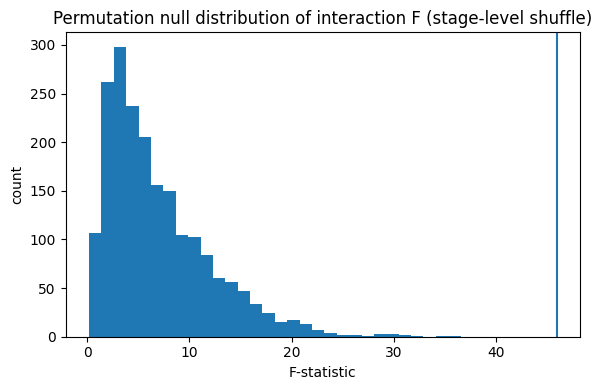

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(F_null, bins=30)
plt.axvline(F_obs)
plt.title("Permutation null distribution of interaction F (stage-level shuffle)")
plt.xlabel("F-statistic")
plt.ylabel("count")
plt.tight_layout()
plt.show()